# "Deep Convolutional Variational Auto Encoders - Part 4"
> "Reduce reduce reduce"

- toc: true
- branch: master
- badges: false
- comments: true
- use_plotly: true
- author: Max Worgan
- categories: [dimension reduction, auto-encoder, swarm]

# Introduction

We're now experimenting with a swarm of a 100 (so I can fit my model on the GPUs I have avaliable) and reduce down to a 10 dimentional latent space.

In [1]:
using DrWatson
quickactivate(@__DIR__)
using Flux.Data: DataLoader
using Flux, DataFrames, StatsBase,MLDataPattern, CUDA, PlotlyJS, LegolasFlux, CSV
using Blink
#using Wandb, Dates,Logging

WebIO._IJuliaInit()

In [3]:

function create_vae()
    
  encoder_features = Chain(
        # 60x300xb
        Conv((9,), 300 => 3000, relu; pad = SamePad()),
        MaxPool((2,)),
        # 30x3000xb
        Conv((5,), 3000 => 1500, relu; pad = SamePad()),
        MaxPool((2,)),
        # 15x4500xb
        Conv((5,),1500 => 750, relu; pad = SamePad()),
        # 15x2250xb
        MaxPool((3,)),
        Conv((3,),750 => 250, relu; pad = SamePad()),
        Conv((3,),250 => 25, relu; pad = SamePad()),
        Conv((3,),25 => 10, relu; pad = SamePad()),
        # 5x25xb
        Flux.flatten,
        Dense(50,10,relu)
      )

    encoder_μ      = Chain(encoder_features, Dense(10,10))

    encoder_logvar = Chain(encoder_features, Dense(10,10))

    decoder = Chain(
        Dense(10,50,relu),
        (x -> reshape(x, 5,10,:)),
          # 5x100xb
        ConvTranspose((3,), 10  => 25, relu; pad = SamePad()),
        ConvTranspose((3,), 25  => 250, relu; pad = SamePad()),
        ConvTranspose((3,), 250 => 750, relu; pad = SamePad()),
        Upsample((3,)),
        # 15x2250xb
        ConvTranspose((5,), 750 => 1500 , relu; pad = SamePad()),
        Upsample((2,)),
        # 30x4500xb
        ConvTranspose((5,), 1500 => 3000, relu; pad = SamePad()),
        Upsample((2,)),
        # 60x9000xb
        ConvTranspose((9,), 3000 => 300; pad = SamePad()),
        # 60x900xb
      )
      return (encoder_μ, encoder_logvar, decoder)
    
end

create_vae (generic function with 1 method)

In [4]:
#load the data
df = DataFrame(CSV.File(projectdir("data/exp_raw","data_large.csv"); header=false, types=Float32));

In [5]:
function normalise(M) 
    min_m = minimum(M)
    max_m = maximum(M)
    return (M .- min_m) ./ (max_m - min_m)
end

normalised = Array(df) |> normalise

window_size = 60

data = slidingwindow(normalised',window_size,stride=1)

train_set, validate_set, test_set = splitobs(shuffleobs(data), (0.7,0.2));


In [6]:
encoder_μ, encoder_logvar, decoder = create_vae() 
model = Chain(encoder_μ, encoder_logvar, decoder)
model_row = read_model_row(projectdir("models","100agents-10dims.arrow"))
load_weights!(model, model_row.weights)

In [7]:
#hide
using PlotlyJS, Plots, KissSmoothing


@userplot FlockPlot
@recipe function f(cp::FlockPlot)
    x,y,z = cp.args
    color := :black
    label --> false
    seriestype := :scatter
    alpha := 0.75
    markersize := 1
    xlim := (0, 1)
    ylim := (0, 1)
    zlim := (0, 1)
    x, y, z
end
function create_gif_from_raw(data)
    t = reshape(getobs(data), 3, 100, 60)
    t = permutedims(t, [2,3,1])
    anim = @animate for i ∈ 1:60
        flockplot(t[:,i,1], t[:,i,2], t[:,i,3])
    end
    gif(anim, "anim_fps30.gif", fps=30)
end
    

create_gif_from_raw (generic function with 1 method)

┌ Info: Saved animation to /Users/max/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/Users/max/Swarm/notebooks/anim_fps30.gif")
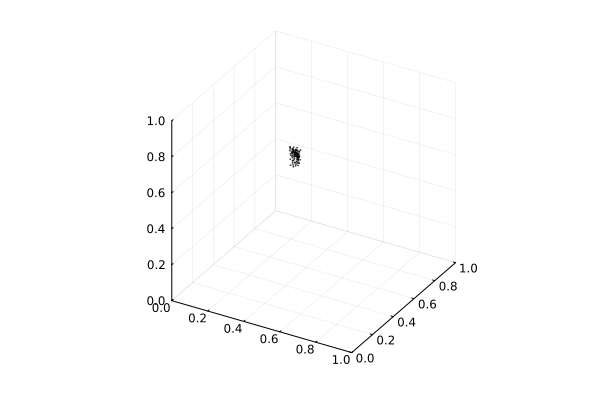

In [8]:
#lets grab a random window of data and visualise it
test_data = rand(test_set)
create_gif_from_raw(test_data)

In [9]:
function reconstruct(x) # x should be 60x300x1
    @assert(size(x) == (60,300,1))
    μ = encoder_μ(x)
    logσ = encoder_logvar(x)
    z = μ + cpu(randn(Float32, size(logσ))) .* exp.(logσ)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    x̂ = denoise(x̂ .|> Float64; dims=1)[1]
    return reshape(x̂, 60,300)'
end

reconstruct (generic function with 1 method)

┌ Info: Saved animation to /Users/max/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/Users/max/Swarm/notebooks/anim_fps30.gif")
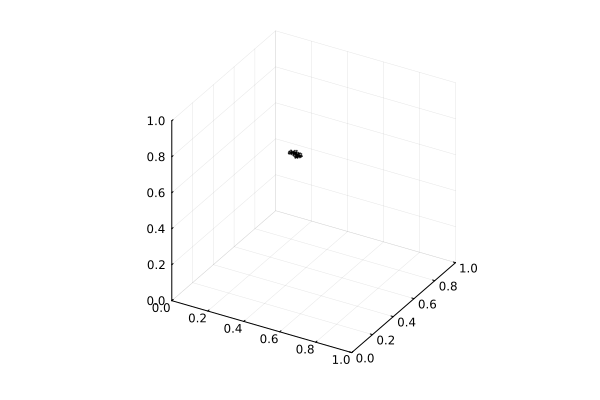

In [10]:
#now lets push that window through our autoencoder and visualise the reconstruction
x = getobs(Flux.unsqueeze(test_data', 3))
recon = reconstruct(x)

create_gif_from_raw(recon)

In [11]:
μ = encoder_μ(x)
logvar = encoder_logvar(x)

z = μ + randn(Float32, size(logvar)) .* exp.(logvar)

μ

10×1 Matrix{Float32}:
 -6.046209
  0.03290136
  0.26940033
 -4.513956
  0.1899449
 -2.0077553
  2.2325406
 -4.89065
  1.6356429
  2.5268512

┌ Info: Float32[-6.046209; 0.03290136; 0.26940033; -4.513956; 0.1899449; -2.0077553; 2.2325406; -4.89065; 1.6356429; 2.5268512;;]
└ @ Main In[12]:1
┌ Info: Saved animation to /Users/max/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/Users/max/Swarm/notebooks/anim_fps30.gif")
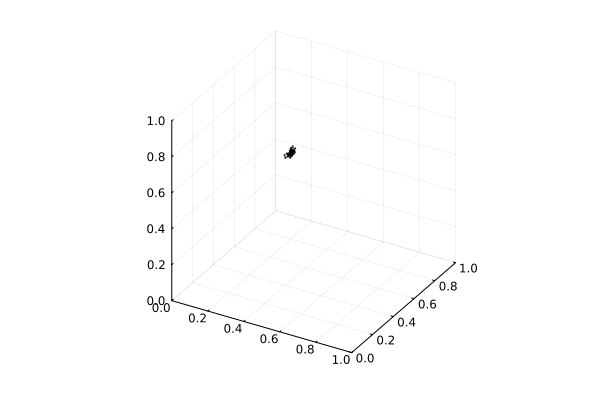

In [12]:
@info μ
μ[1] = -5.6
create_gif_from_raw(denoise(reshape(decoder(μ), 60,300)' .|> Float64)[1])



In [13]:
using Blink: Window, body!
using Interact: @manipulate
using Plots: plot, plotlyjs

In [ ]:
w = Window()
##

x = range(0, 6π; length=1000)
ui = @manipulate for i in 1:10
  plot(sin.(i .* x) .* cos.(i .* 2x))
end

body!(w, ui)

In [ ]:
ui = button()
display(ui)

filepicker() |> display # value is the path of selected file

In [ ]:
create_gif_from_raw(denoise(recon .|> Float64; factor=1.0)[1])

In [ ]:
using Pkg
Pkg.add("Interact")

In [ ]:
#z[1] = z[1] - 0.1
x̂ = (decoder |> cpu)(z)
#output = reshape(x̂, 60,900)'
@info axes(x̂)
#output = denoise(reshape(x̂, 60,900)' .|> Float64)[1]  .|> Float32
output = reshape(denoise(x̂ .|> Float64; dims=1)[1] .|> Float32, 60,900)'

create_gif_from_raw(output)

In [ ]:
z = rand(100,1) * 20 .- 10 |> f32


In [ ]:
z[7] = -10
x̂ = (decoder |> cpu)(z)
output = reshape(x̂, 60,900)'
create_gif_from_raw(output)